# Implementing LSTM Neural Network for Serbian name generation
Dataset: srpska-imena <br>
Link: https://github.com/fondacija-glasnik/srpska-imena

### Import required modules

In [812]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

### Load the dataset

In [813]:
dataset_path = r"SrpskaImena.csv"
data = pd.read_csv(dataset_path)
names = data['Name'].to_list()
names = [name.lower() for name in names]

names = np.array(names)

In [814]:
print(f"Data Shape = {names.shape}")
print()
print("Lets see some names: ")
print(names[1:10])

Data Shape = (815,)

Lets see some names: 
['antonije' 'arandjel' 'arsenije' 'atanasije' 'acim' 'aca' 'aco' 'adam'
 'aksentije']


### Transform the data
Find the longest name and append dots ('.') to every other name until its length matches the longest one.

In [815]:
longest_name_len = max(list(map(lambda x: len(x), names)))
transformed_names = np.array(list(map(lambda name: name + '.'*(longest_name_len - len(name)), names)))

print(transformed_names[:10])

['avram......' 'antonije...' 'arandjel...' 'arsenije...' 'atanasije..'
 'acim.......' 'aca........' 'aco........' 'adam.......' 'aksentije..']


### Let's create the vocabulary based on our dataset

In [816]:
vocab = []
for name in transformed_names:
    vocab.extend(list(name))
vocab = set(vocab)
vocab_size = len(vocab)

print(f"Vocab size = {vocab_size}")
print(f"Vocab      = {vocab}")

Vocab size = 25
Vocab      = {'g', ' ', 'r', 't', 'c', 'z', 'n', 'f', 'l', 'u', 'm', 'e', 's', 'k', 'h', '.', '|', 'p', 'd', 'b', 'o', 'j', 'i', 'v', 'a'}


### Character to idx (and vice-versa) mapping

In [817]:
char_to_idx = {c:i for i, c in enumerate(vocab)}
idx_to_char = {i:c for i, c in enumerate(vocab)}

a_idx = char_to_idx['a']
print(f"a-{a_idx}, {a_idx}-{idx_to_char[a_idx]}")

a-24, 24-a


### We'll split the dataset into batches of a certain size

In [818]:
X_train = []
batch_size = 16

for i in range(len(transformed_names)//batch_size):
    X_train.append([list(name) for name in transformed_names[i*batch_size:(i+1)*batch_size]])
    print(X_train[-1])

[['a', 'v', 'r', 'a', 'm', '.', '.', '.', '.', '.', '.'], ['a', 'n', 't', 'o', 'n', 'i', 'j', 'e', '.', '.', '.'], ['a', 'r', 'a', 'n', 'd', 'j', 'e', 'l', '.', '.', '.'], ['a', 'r', 's', 'e', 'n', 'i', 'j', 'e', '.', '.', '.'], ['a', 't', 'a', 'n', 'a', 's', 'i', 'j', 'e', '.', '.'], ['a', 'c', 'i', 'm', '.', '.', '.', '.', '.', '.', '.'], ['a', 'c', 'a', '.', '.', '.', '.', '.', '.', '.', '.'], ['a', 'c', 'o', '.', '.', '.', '.', '.', '.', '.', '.'], ['a', 'd', 'a', 'm', '.', '.', '.', '.', '.', '.', '.'], ['a', 'k', 's', 'e', 'n', 't', 'i', 'j', 'e', '.', '.'], ['a', 'l', 'e', 'k', 's', 'a', '.', '.', '.', '.', '.'], ['a', 'l', 'e', 'k', 's', 'a', 'n', 'd', 'a', 'r', '.'], ['a', 'l', 'i', 'm', 'p', 'i', 'j', 'e', '.', '.', '.'], ['a', 'n', 'd', 'j', 'e', 'l', 'k', 'o', '.', '.', '.'], ['a', 'n', 'd', 'r', 'i', 'j', 'a', '.', '.', '.', '.'], ['b', 'a', 'n', 'e', '.', '.', '.', '.', '.', '.', '.']]
[['b', 'l', 'a', 'g', 'o', 'j', 'e', '.', '.', '.', '.'], ['b', 'l', 'a', 'g', 'o', 'm'

### Hyperparameters

In [819]:
hidden_size = 256
input_size = vocab_size + hidden_size
output_size = vocab_size

learning_rate = 0.005

### Activation functions and their derivatives
Tanh: https://en.wikipedia.org/wiki/Hyperbolic_functions#Tanh <br>
Sigmoid: https://en.wikipedia.org/wiki/Sigmoid_function <br>
Softmax: https://en.wikipedia.org/wiki/Softmax_function

In [820]:
def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)
def dtanh(x: np.ndarray) -> np.ndarray:
    return 1 - np.tanh(x)**2

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))
def dsigmoid(x: np.ndarray) -> np.ndarray:
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x: np.ndarray) -> np.ndarray:
    exp = np.exp(x)
    return exp/np.sum(exp)

### Helper functions
One-hot encoding: https://en.wikipedia.org/wiki/One-hot
Weight initialization: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

In [821]:
def one_hot_encode(c: str) -> np.ndarray:
    one_hot = np.zeros((vocab_size, 1))
    one_hot[char_to_idx[c]] = 1
    
    return one_hot

def init_weights(input_size: int, output_size: int) -> np.ndarray:
    # Normalized Xavier initialization
    return np.random.uniform(-1, 1, (input_size, output_size)) * np.sqrt(6/(input_size + output_size))

### Defining the LSTM class

In [822]:
class LSTM:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, learning_rate: float = 1e-3):
        # Hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Forget gate weights
        self.W_f = init_weights(input_size, hidden_size)
        self.b_f = np.zeros((hidden_size, 1))

        # Input gate weights
        self.W_i = init_weights(input_size, hidden_size)
        self.b_i = np.zeros((hidden_size, 1))

        # Candidate gate weights
        self.W_c = init_weights(input_size, hidden_size)
        self.b_c = np.zeros((hidden_size, 1))

        # Output gate weights
        self.W_o = init_weights(input_size, hidden_size)
        self.b_o = np.zeros((hidden_size, 1))

        # Final gate weights
        self.W_y = init_weights(hidden_size, output_size)
        self.b_y = np.zeros((output_size, 1))
        
        # Network cache
        self.concat_inputs: dict[int, np.ndarray] = {}

        self.hidden_states: dict[int, np.ndarray] = {-1: np.zeros((hidden_size, 1))}
        self.cell_states: dict[int, np.ndarray] = {-1: np.zeros((hidden_size, 1))}

        self.forget_gates: dict[int, np.ndarray] = {}
        self.input_gates: dict[int, np.ndarray] = {}
        self.candidate_gates: dict[int, np.ndarray] = {}
        self.output_gates: dict[int, np.ndarray] = {}
        self.activation_outputs: dict[int, np.ndarray] = {}
        self.outputs: dict[int, np.ndarray] = {}
        
    def reset_cache(self):
        self.concat_inputs = {}
        
        self.hidden_states = {-1: np.zeros((hidden_size, 1))}
        self.cell_states = {-1: np.zeros((hidden_size, 1))}
        
        self.forget_gates = {}
        self.input_gates = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.activation_outputs = {}
        self.outputs = {}
        
    def forward(self, inputs: list[np.ndarray]) -> list[np.ndarray]:
        self.reset_cache()
        
        outputs = []
        for t in range(len(inputs)):
            self.concat_inputs[t] = np.concatenate((self.hidden_states[t-1], inputs[t]))
            
            self.forget_gates[t] = np.dot(self.W_f.T, self.concat_inputs[t]) + self.b_f
            self.input_gates[t] = np.dot(self.W_i.T, self.concat_inputs[t]) + self.b_i
            self.candidate_gates[t] = np.dot(self.W_c.T, self.concat_inputs[t]) + self.b_c
            self.output_gates[t] = np.dot(self.W_o.T, self.concat_inputs[t]) + self.b_o
            
            fga = sigmoid(self.forget_gates[t])
            iga = sigmoid(self.input_gates[t])
            cga = tanh(self.candidate_gates[t])
            oga = sigmoid(self.output_gates[t])
            
            self.cell_states[t] = fga * self.cell_states[t-1] + iga * cga
            self.hidden_states[t] = oga * tanh(self.cell_states[t])
            
            logits = np.dot(self.W_y.T, self.hidden_states[t]) + self.b_y
            outputs += [softmax(logits)]
            
        return outputs
    
    def backward(self, errors: list[np.ndarray]) -> None:
        dW_f = 0
        db_f = 0
        
        dW_i = 0
        db_i = 0
        
        dW_c = 0
        db_c = 0
        
        dW_o = 0
        db_o = 0
        
        dW_y = 0
        db_y = 0
        
        hidden_state = np.zeros_like(self.hidden_states[0])
        cell_state = np.zeros_like(self.cell_states[0])
        
        for t in reversed(range(len(self.concat_inputs))):
            err = errors[t]
            dW_y += np.dot(err, self.hidden_states[t].T)
            db_y += err
            
            dhidden = np.dot(self.W_y, err) + hidden_state
            doutput = tanh(self.cell_states[t]) * dhidden * dsigmoid(self.output_gates[t])
            
            dW_o += np.dot(doutput, self.concat_inputs[t].T)
            db_o += doutput
            
            dcell_state = dtanh(self.cell_states[t]) * self.output_gates[t] * dhidden + cell_state
            
            dforget = dcell_state * self.cell_states[t-1] * dsigmoid(self.forget_gates[t])
            
            dW_f += np.dot(dforget, self.concat_inputs[t].T)
            db_f += dforget
            
            dinput = dcell_state * self.candidate_gates[t] * dsigmoid(self.input_gates[t])
            
            dW_i += np.dot(dinput, self.concat_inputs[t].T)
            db_i += dinput
            
            dcandidate = dcell_state * self.input_gates[t] * dtanh(self.candidate_gates[t])
            
            dW_c += np.dot(dcandidate, self.concat_inputs[t].T)
            db_c += dcandidate
            
            d_concat_inputs = np.dot(self.W_f, dforget) + np.dot(self.W_i, dinput) + np.dot(self.W_c, dcandidate) + np.dot(self.W_o, doutput)
            
            hidden_state = d_concat_inputs[:self.hidden_size, :]
            cell_state = self.forget_gates[t] * dcell_state
            
        for _d in (dW_f, db_f, dW_i, db_i, dW_c, db_c, dW_o, db_o, dW_y, db_y):
            np.clip(_d, -1, 1, out=_d)
            
        self.W_f -= dW_f.T * self.learning_rate
        self.b_f -= db_f * self.learning_rate
        
        self.W_i -= dW_i.T * self.learning_rate
        self.b_i -= db_i * self.learning_rate
        
        self.W_c -= dW_c.T * self.learning_rate
        self.b_c -= db_c * self.learning_rate
        
        self.W_o -= dW_o.T * self.learning_rate
        self.b_o -= db_o * self.learning_rate
        
        self.W_y -= dW_y.T * self.learning_rate
        self.b_y -= db_y * self.learning_rate
        
    def train(self, inputs: list[list[list[str]]], epochs: int = 10):
        L = []
        for _ in tqdm.tqdm(range(epochs)):
            for batch in inputs:
                loss = 0.0
                for name in batch:
                    one_hot_chars = [one_hot_encode(char) for char in name]
                    
                    predictions = self.forward(one_hot_chars)
                        
                    errors = []
                    for i in range(len(predictions)):
                        # errors += [-np.sum(one_hot_chars * np.log(predictions[i]))]
                        errors += [predictions[i]]
                        errors[-1][char_to_idx[name[i]]] -= 1
                    
                    for err in errors:
                        loss += np.sum(np.abs(err))
                    
                    self.backward(errors)
                L.append(loss / len(batch))
        return L

### Network initialization, training and testing

In [823]:
lstm = LSTM(input_size, hidden_size, output_size)

#### Training ####
L = lstm.train(X_train)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:15<00:00, 13.53s/it]


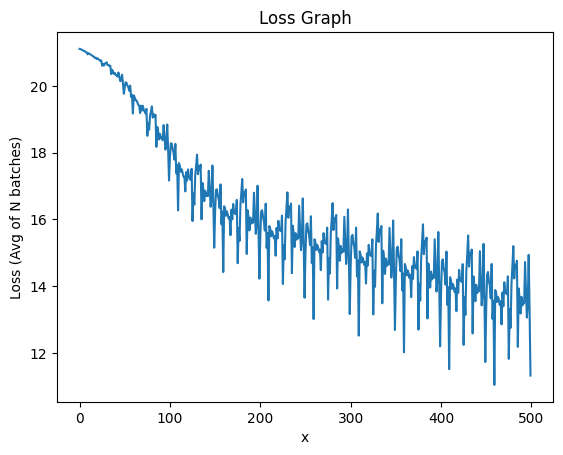

In [824]:
plt.plot(list(range(len(L))),L)
plt.xlabel("x")
plt.ylabel("Loss (Avg of N batches)")
plt.title("Loss Graph")
plt.show()